In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray
from skimage.filters import gaussian

import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure, filters, measure
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage import morphology
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.io import imread

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.16.2'

In [2]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)
tf.debugging.set_log_device_placement(False)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


# Task2: Cell type classification

## Problem statement

**Objective**:
The objective of this task is to classify cell type data, which consists of four distinct categories: a, b, c, and others. This problem is framed as a multi-class classification problem, where each sample (an image of a cell) must be assigned one of the four labels based on its features. The dataset is imbalanced, meaning certain classes have far fewer samples than others, which introduces challenges in model evaluation.

**Metric Selection**:
Given the class imbalance present in the dataset, accuracy alone is not a sufficient evaluation metric. In this context, the weighted F1 score is the preferred metric. The F1 score is the harmonic mean of precision and recall, and it balances these two metrics to provide a more comprehensive evaluation.
Since we have an imbalanced dataset, the weighted F1 score is particularly useful because it gives more weight to the larger classes while still considering performance on the smaller classes. This helps ensure that the model performs well across all classes, not just the majority class, and avoids the bias that could arise from imbalanced class distributions. The weighted F1 score is calculated by averaging the F1 scores of each class, weighted by the number of instances in that class. This approach ensures that the model’s performance on minority classes is not overlooked.

**Baseline Model**:
For a baseline model, we will start with a Random Forest classifier. Random Forest is chosen because it is a robust, interpretable model well-suited for classification tasks, and it performs well on medium-sized datasets. Random Forest does not require extensive hyperparameter tuning and can provide a solid baseline for comparison with more advanced models.

**Improvement through Neural Networks**:
To improve upon the baseline, we will experiment with Neural Networks (NN) and Convolutional Neural Networks (CNNs). Neural networks, particularly CNNs, are highly specialized for image classification tasks as they can automatically learn hierarchical features and patterns from image data. CNNs have been shown to outperform traditional machine learning models in many image-related tasks due to their ability to capture spatial relationships in images. These models are expected to provide a significant boost in performance compared to the Random Forest baseline.

In [3]:
# Loading the data:
cell_type_train = pd.read_csv('./data/train.csv')
cell_type_train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,19035,2,19035.png,fibroblast,0,0
1,19036,2,19036.png,fibroblast,0,0
2,19037,2,19037.png,fibroblast,0,0
3,19038,2,19038.png,fibroblast,0,0
4,19039,2,19039.png,fibroblast,0,0


In [4]:
cell_type_test = pd.read_csv('./data/test.csv')
cell_type_test.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Baseline development

For the baseline models, traditionals approaches, which support multiclass classification, are used, which are:
- Random Forest classifier:
- Support Vector Machine:

As the imbalance issue also happens for the cell type, data augmentation is used. Also, K-Fold is used for training and evaluating the Traditional Machine Learning approaches. 

### Features extraction
As the traditional machine learning approach could not handle the images as the input, so feature extracting is required to perform. 

In [65]:
sampled_df = cell_type_train.groupby('cellTypeName').sample(n=1, random_state=42).reset_index(drop=True)

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern
from skimage import exposure, filters
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian

def process_and_plot(image_path, title=""):
    # Load and preprocess image
    image = imread(image_path)
    grayscale = rgb2gray(image)

    # Gaussian smoothing
    smooth_1 = gaussian(image, sigma=1, channel_axis=-1)
    smooth_10 = gaussian(image, sigma=10, channel_axis=-1)

    # Sobel edge detection
    smooth_gray = gaussian(grayscale, sigma=1)
    edge_h = filters.sobel_h(smooth_gray)
    edge_v = filters.sobel_v(smooth_gray)

    # LBP feature extraction
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(grayscale, n_points, radius, method='uniform')

    # Normalize LBP histogram as feature vector
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid divide by zero

    # Plot all results in a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(6, 5))
    fig.suptitle(title, fontsize=16)

    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(smooth_1)
    axes[0, 1].set_title("Gaussian sigma=1")
    axes[0, 1].axis('off')

    axes[0, 2].imshow(smooth_10)
    axes[0, 2].set_title("Gaussian sigma=10")
    axes[0, 2].axis('off')

    axes[1, 0].imshow(edge_h, cmap='coolwarm')
    axes[1, 0].set_title("Sobel Horizontal")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(edge_v, cmap='coolwarm')
    axes[1, 1].set_title("Sobel Vertical")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(lbp, cmap='gray')
    axes[1, 2].set_title("LBP")
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print stats
    print(f"{title} -> Image shape: {image.shape}, Flattened: {np.prod(image.shape)}")
    print(f"{title} -> LBP hist shape: {lbp_hist.shape}, Sum: {np.sum(lbp_hist):.2f}")


In [115]:
# This function is used to extract the features, when training the data
class ImageFeatureExtractor:
    def process_and_extract_features(self, image_path, title=""):
        # Load and preprocess image
        image = imread(image_path)
        grayscale = rgb2gray(image)
        grayscale = (grayscale * 255).astype(np.uint8) 
    
        # Sobel edge detection
        smooth_gray = gaussian(grayscale, sigma=1) # when setting to sigma to higher value, most of features is gone
        edge_h = filters.sobel_h(smooth_gray)
        edge_v = filters.sobel_v(smooth_gray)
    
        # LBP feature extraction
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(grayscale, n_points, radius, method='uniform')
    
        # Normalize LBP histogram as feature vector
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Avoid divide by zero
    
        # Extract color features (mean and std of RGB channels)
        mean_r = np.mean(image[:, :, 0])
        mean_g = np.mean(image[:, :, 1])
        mean_b = np.mean(image[:, :, 2])
        std_r = np.std(image[:, :, 0])
        std_g = np.std(image[:, :, 1])
        std_b = np.std(image[:, :, 2])
    
        # Threshold and label the image for segmentation (optional: you may have a different method)
        binary_image = grayscale > filters.threshold_otsu(grayscale)
        labeled_image = measure.label(binary_image)
        regions = measure.regionprops(labeled_image)
    
        # Extract shape features (area, perimeter, eccentricity, etc.)
        shape_features = []
        for region in regions:
            if region.area >= 10:  # Filter out small regions (noise)
                shape_features.extend([
                    region.area,
                    region.perimeter,
                    region.eccentricity,
                    region.solidity,
                    region.extent,
                    region.major_axis_length,
                    region.minor_axis_length,
                ])
        
        # Combine all features into one vector
        full_features = np.hstack([
            lbp_hist,
            [mean_r, mean_g, mean_b, std_r, std_g, std_b],
            # shape_features
        ])
    
        return full_features


./data/patch_images/471.png


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


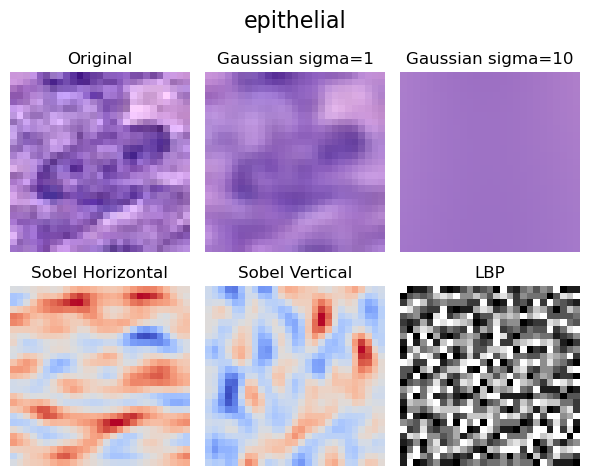

epithelial -> Image shape: (27, 27, 3), Flattened: 2187
epithelial -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/16787.png


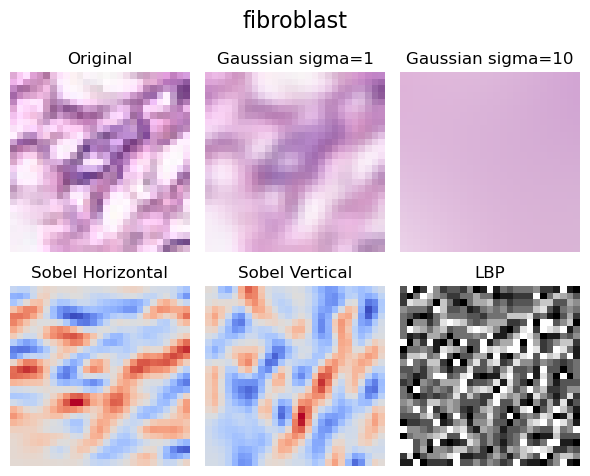

fibroblast -> Image shape: (27, 27, 3), Flattened: 2187
fibroblast -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/4702.png


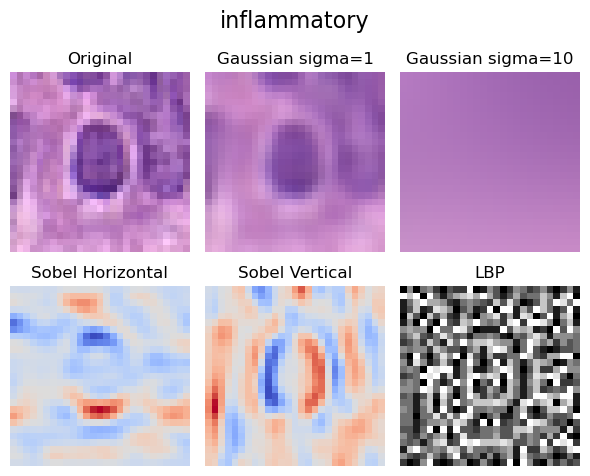

inflammatory -> Image shape: (27, 27, 3), Flattened: 2187
inflammatory -> LBP hist shape: (10,), Sum: 1.00
./data/patch_images/16651.png


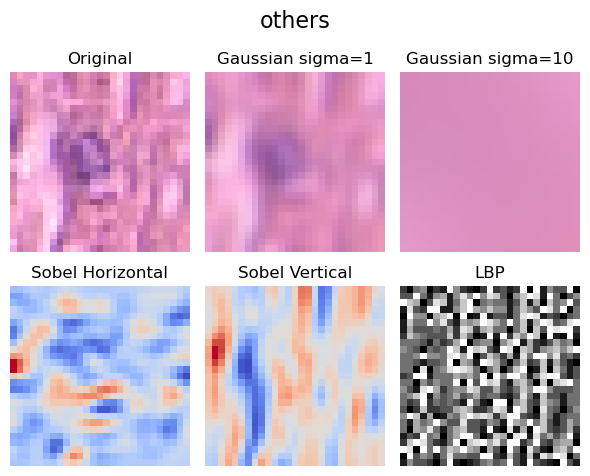

others -> Image shape: (27, 27, 3), Flattened: 2187
others -> LBP hist shape: (10,), Sum: 1.00


In [116]:
# Loop through the 4 sampled images
for idx, row in sampled_df.iterrows():
    image_path = './data/patch_images/' + row['ImageName']
    print(image_path)
    process_and_plot(image_path, title=row['cellTypeName'])


Based on the result of the above analysis, the LBP techniques capture the feature better than HOG. Therefore, the features, will be the combination of 

### Handle the imbalance class
As mentioned earlier, only 


In [147]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

class AugmentedFeatureModel(BaseEstimator, ClassifierMixin):
    def __init__(self, image_dir, classifier_name, classifier=None, random_state=42):
        self.image_dir = image_dir
        self.classifier = classifier if classifier is not None else LogisticRegression(max_iter=1000)
        self.random_state = random_state
        self.feature_extractor = ImageFeatureExtractor()
        self.augment_times = 1
        self.image_aug_dir = f'./data/aug/{classifier_name}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        self.classifier_name = classifier_name

        # Define augmentation strategy
        self.augmentor = ImageDataGenerator(
            rescale=1./255,
            data_format='channels_last',
            rotation_range=15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest'
        )

    def _augment_and_resample(self, X, y):
        import uuid
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image temporarily
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                from PIL import Image
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fpath, 'label': label})
    
            # Add originals
            for _, row in samples.iterrows():
                image_fpath = os.path.join(self.image_dir, row['ImageName'])
                balanced_rows.append({'ImageName': image_fpath, 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced[['ImageName']], df_balanced['label']


    def _extract_features(self, X_df, use_name_only=False):
        features = []
        for fname in X_df['ImageName']:
            if use_name_only is True:
                fname = os.path.join(self.image_dir, fname)
            feat = self.feature_extractor.process_and_extract_features(fname)
            features.append(feat)
        return np.array(features)

    def fit(self, X, y):
        # Augment + extract features
        X_balanced, y_balanced = self._augment_and_resample(X, y)
        self.le_ = LabelEncoder().fit(y_balanced)
        y_encoded = self.le_.transform(y_balanced)
        X_features = self._extract_features(X_balanced)
        self.classes_ = self.le_.classes_
        self.classifier.fit(X_features, y_encoded)
        return self

    def predict(self, X):
        X_features = self._extract_features(X, True)
        y_pred = self.classifier.predict(X_features)
        return self.le_.inverse_transform(y_pred)

    def predict_proba(self, X):
        X_features = self._extract_features(X, True)
        return self.classifier.predict_proba(X_features)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    


### Logistic regression

In [149]:
gkf = GroupKFold(n_splits=5)

folds = list(gkf.split(X, y, groups=groups))
# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(folds):
    # Extract training and validation patient IDs
    train_patient_ids = cell_type_train.iloc[train_idx]['patientID'].unique()
    val_patient_ids = cell_type_train.iloc[val_idx]['patientID'].unique()
    # Check if there is any overlap in patient IDs between train and validation sets
    overlap = set(train_patient_ids).intersection(val_patient_ids)
    if overlap:
        print(f"Data leakage detected in fold {fold + 1}: Overlap in patient IDs {overlap}")
    else:
        print(f"Fold {fold + 1} has no data leakage.")

Fold 1 has no data leakage.
Fold 2 has no data leakage.
Fold 3 has no data leakage.
Fold 4 has no data leakage.
Fold 5 has no data leakage.


In [150]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


def evaluate_model_with_cv(model, model_name, param_grid, image_dir, df_train, df_test, folds, label_column='cellTypeName'):
    X_train = df_train[['ImageName']]
    y_train = df_train[label_column]
    groups = df_train['patientID']

    X_test = df_test[['ImageName']]
    y_test = df_test[label_column]

    # Wrap the model in AugmentedFeatureModel
    wrapped_model = AugmentedFeatureModel(
        image_dir=image_dir,
        classifier_name=model_name,
        classifier=model
    )

    grid = GridSearchCV(
        estimator=wrapped_model,
        param_grid=param_grid,
        cv=folds,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )

    print("🔍 Starting Grid Search...")
    grid.fit(X_train, y_train)
    print("✅ Best score:", grid.best_score_)
    print("✅ Best params:", grid.best_params_)

    # Final evaluation on the test set
    print("\n📊 Evaluating best model on test set...")
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_true = y_test

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred))

    # ROC Curve (for multiclass)
    print("📈 Generating ROC Curve...")
    y_score = best_model.predict_proba(X_test)
    class_names = best_model.classes_
    y_true_bin = label_binarize(y_true, classes=class_names)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    plt.figure(figsize=(8, 6))
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name],
                 label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


🔍 Starting Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best score: 0.6124735587527871
✅ Best params: {'classifier__C': 1}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.83      0.89      0.86      1051
  fibroblast       0.66      0.55      0.60       307
inflammatory       0.74      0.82      0.78       618
      others       0.24      0.09      0.13       152

    accuracy                           0.77      2128
   macro avg       0.62      0.59      0.59      2128
weighted avg       0.74      0.77      0.75      2128

📈 Generating ROC Curve...


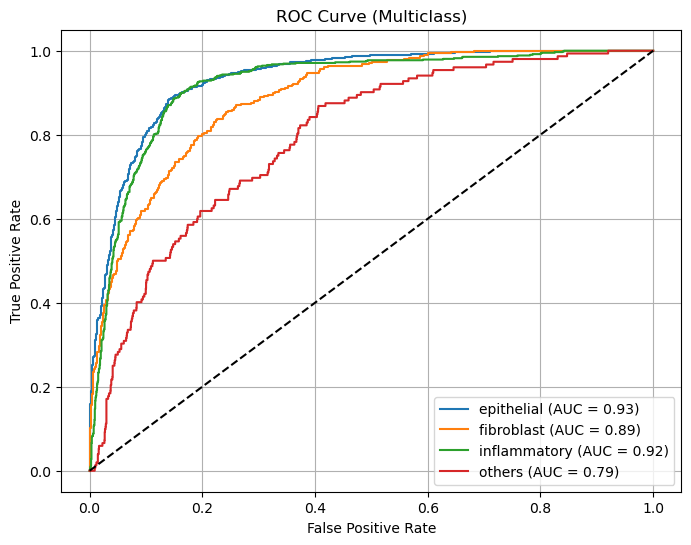

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Example: Logistic Regression
evaluate_model_with_cv(
    model=LogisticRegression(max_iter=100000, multi_class='multinomial', solver='lbfgs'),
    model_name="aug_logistic_clf",
    param_grid={'classifier__C': [0.1, 1, 10]},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)

### Random forest

🔍 Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best score: 0.6149975995435646
✅ Best params: {'classifier__max_depth': None, 'classifier__n_estimators': 100}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.78      0.87      0.83      1051
  fibroblast       0.58      0.52      0.55       307
inflammatory       0.72      0.69      0.71       618
      others       0.57      0.36      0.44       152

    accuracy                           0.73      2128
   macro avg       0.67      0.61      0.63      2128
weighted avg       0.72      0.73      0.72      2128

📈 Generating ROC Curve...


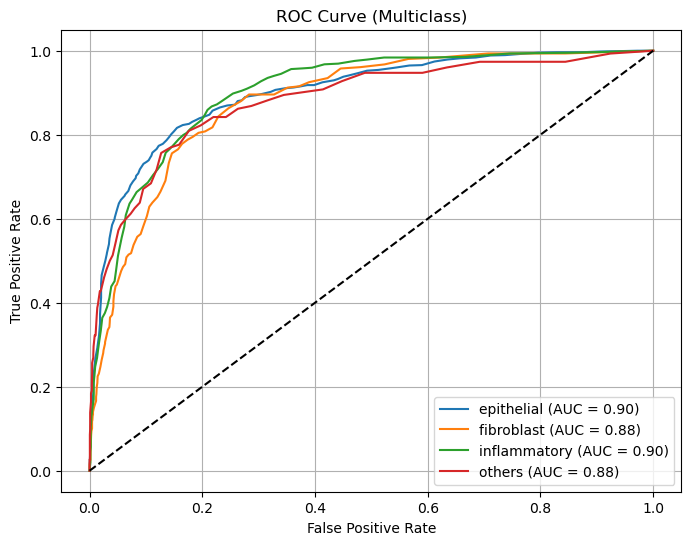

In [153]:
# Example: Random Forest
evaluate_model_with_cv(
    model=RandomForestClassifier(),
    model_name='aug_logistic_rf',
    param_grid={'classifier__n_estimators': [50, 100], 'classifier__max_depth': [None, 10]},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)


### Support Vector Machine

🔍 Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best score: 0.6188687508991612
✅ Best params: {'classifier__C': 10, 'classifier__kernel': 'linear'}

📊 Evaluating best model on test set...

📄 Classification Report:
              precision    recall  f1-score   support

  epithelial       0.83      0.88      0.85      1051
  fibroblast       0.60      0.55      0.57       307
inflammatory       0.74      0.82      0.78       618
      others       0.30      0.11      0.16       152

    accuracy                           0.76      2128
   macro avg       0.62      0.59      0.59      2128
weighted avg       0.73      0.76      0.74      2128

📈 Generating ROC Curve...


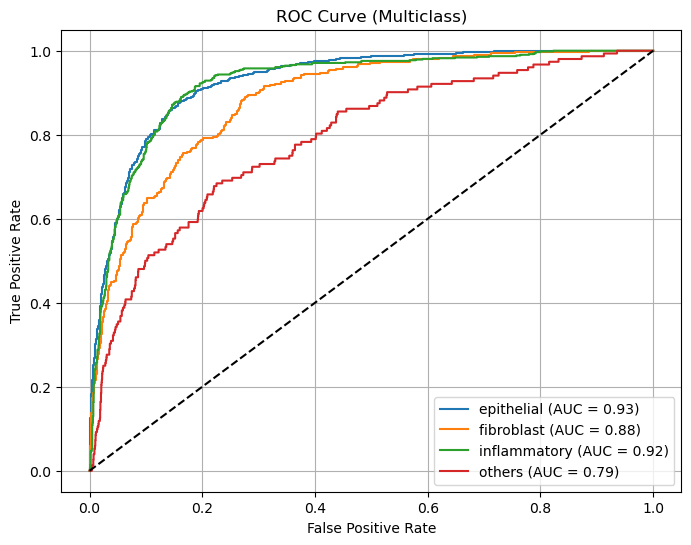

In [154]:

# Example: SVM
evaluate_model_with_cv(
    model=SVC(probability=True),  # `probability=True` needed for ROC
    model_name='aug_logistic_svm',
    param_grid={'classifier__C': [1, 10], 'classifier__kernel': ['linear', 'rbf']},
    image_dir='./data/patch_images',
    df_train=cell_type_train,
    df_test=cell_type_test,
    folds=folds
)

## Deep learning based approach

With deep learning approach, K-Fold validation could not be used as to split the train and validation set as training neural network is time-consuming process. 

In [125]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Group patients and their unique cell types
patient_classes = cell_type_train.groupby('patientID')['cellType'].apply(lambda x: set(x)).reset_index()
patient_classes['cellType'] = patient_classes['cellType'].apply(list)

# 2. Create a list of patient IDs per class
from collections import defaultdict
class_to_patients = defaultdict(set)

for idx, row in patient_classes.iterrows():
    for c in row['cellType']:
        class_to_patients[c].add(row['patientID'])

# 3. Ensure each class is present in the validation set
val_patient_ids = set()
for c in class_to_patients:
    val_patient_ids.add(next(iter(class_to_patients[c])))  # Pick one patient from each class

# 4. Fill the rest of the val set to reach desired size
remaining_patients = set(cell_type_train['patientID'].unique()) - val_patient_ids
remaining_needed = int(len(cell_type_train['patientID'].unique()) * 0.2) - len(val_patient_ids)
if remaining_needed > 0:
    extra_val_ids = set(list(remaining_patients)[:remaining_needed])
    val_patient_ids.update(extra_val_ids)

# 5. Split
train_patient_ids = set(cell_type_train['patientID'].unique()) - val_patient_ids

# 6. Create masks
train_mask = cell_type_train['patientID'].isin(train_patient_ids)
val_mask = cell_type_train['patientID'].isin(val_patient_ids)

# 7. Final splits
nn_train_celtype = cell_type_train[train_mask].reset_index(drop=True)
nn_val_celtype = cell_type_train[val_mask].reset_index(drop=True)

# Confirm cell type presence
print("Train classes:", nn_train_celtype['cellType'].value_counts())
print("Val classes:", nn_val_celtype['cellType'].value_counts())


# Step 5: Confirm no data leakage
overlap = set(nn_train_celtype['patientID']).intersection(set(nn_val_celtype['patientID']))
if overlap:
    print(f"Data leakage detected: {overlap}")
else:
    print("No data leakage: train and validation sets are clean.")


Train classes: cellType
2    2467
1    1281
0    1232
3    1182
Name: count, dtype: int64
Val classes: cellType
1    644
2    561
0    349
3     52
Name: count, dtype: int64
No data leakage: train and validation sets are clean.


In [126]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random
import matplotlib.pyplot as plt

class CustomDataAugmentor:
    def __init__(self):
        # Basic rescaling only for the standard generator
        self.base_generator = ImageDataGenerator(
            rescale=1. / 255,
            data_format='channels_last'
        )
    
    def augment_batch(self, X_batch, y_batch=None):
        """
        Apply custom augmentations to a batch of images as described in the paper:
        - Specific rotations (0°, 90°, 180°, 270°)
        - Vertical or horizontal flipping
        - HSV color perturbation
        - Location variations
        """
        augmented_images = []
        augmented_labels = []
        
        for i, img in enumerate(X_batch):
            # Make a copy of the original image
            augmented_img = img.copy()
            
            # 1. Apply one of the specific rotations (0°, 90°, 180°, 270°)
            rotation_angle = random.choice([0, 90, 180, 270])
            if rotation_angle > 0:
                if rotation_angle == 90:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_90_CLOCKWISE)
                elif rotation_angle == 180:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_180)
                elif rotation_angle == 270:
                    augmented_img = cv2.rotate(augmented_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
            # 2. Apply random horizontal or vertical flipping
            if random.random() < 0.5:
                augmented_img = cv2.flip(augmented_img, 1)  # horizontal flip
            if random.random() < 0.5:
                augmented_img = cv2.flip(augmented_img, 0)  # vertical flip
            
            # 3. Apply HSV color perturbation as described in the paper
            if random.random() < 0.7:  # Apply color augmentation with 70% probability
                # Convert to HSV
                hsv_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2HSV).astype(np.float32)
                
                # Random factors for H, S, and V as described in the paper
                h_factor = random.uniform(0.8, 1.2)  # Random factor for Hue
                s_factor = random.uniform(0.8, 1.2)  # Random factor for Saturation
                v_factor = random.uniform(0.8, 1.2)  # Random factor for Value
                
                # Apply the random factors
                hsv_img[:, :, 0] = np.clip(hsv_img[:, :, 0] * h_factor, 0, 179)  # H has range [0, 179] in OpenCV
                hsv_img[:, :, 1] = np.clip(hsv_img[:, :, 1] * s_factor, 0, 255)  # S has range [0, 255]
                hsv_img[:, :, 2] = np.clip(hsv_img[:, :, 2] * v_factor, 0, 255)  # V has range [0, 255]
                
                # Convert back to RGB
                augmented_img = cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)
            
            # 4. Apply location variance (similar to what's mentioned in the paper about different locations)
            if random.random() < 0.5:
                # Apply random shift within the image
                height, width = augmented_img.shape[:2]
                max_shift_h = height // 5  # Allow shifting up to 20% of height
                max_shift_w = width // 5   # Allow shifting up to 20% of width
                
                shift_h = random.randint(-max_shift_h, max_shift_h)
                shift_w = random.randint(-max_shift_w, max_shift_w)
                
                # Create transformation matrix for shifting
                M = np.float32([[1, 0, shift_w], [0, 1, shift_h]])
                augmented_img = cv2.warpAffine(augmented_img, M, (width, height), borderMode=cv2.BORDER_REFLECT_101)
            
            # Rescale to [0, 1] as the original generator does
            augmented_img = augmented_img / 255.0
            
            augmented_images.append(augmented_img)
            if y_batch is not None:
                augmented_labels.append(y_batch[i])
        
        return np.array(augmented_images), np.array(augmented_labels) if y_batch is not None else None
    
    def flow_from_directory(self, directory, **kwargs):
        """
        Create a generator that yields augmented batches from a directory
        """
        base_gen = self.base_generator.flow_from_directory(directory, **kwargs)
        
        while True:
            X_batch = next(base_gen)
            aug_X_batch = self.augment_batch(X_batch, y_batch)
            yield aug_X_batch, aug_y_batch
    
    def flow(self, X, y=None, **kwargs):
        """
        Create a generator that yields augmented batches from memory
        """
        base_gen = self.base_generator.flow(X, y, **kwargs)
        
        while True:
            # Handle the case where y is None (no labels)
            batch = next(base_gen)
            if y is None:
                X_batch = batch
                y_batch = None
            else:
                X_batch, y_batch = batch
                
            aug_X_batch, aug_y_batch = self.augment_batch(X_batch, y_batch)
            
            if y is None:
                yield aug_X_batch
            else:
                yield aug_X_batch, aug_y_batch

In [210]:
import os
import uuid
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import shutil
import math

class AugmentedImageModel:
    def __init__(self, image_dir, model, class_names, random_state=42, classifier_name="neural_net"):
        self.image_dir = image_dir
        self.model = model
        self.random_state = random_state
        self.class_names = class_names
        self.image_aug_dir = f'./data/aug/{classifier_name}'
        os.makedirs(self.image_aug_dir, exist_ok=True)
        self.classifier_name = classifier_name
        self.augmentor = CustomDataAugmentor()
        self.final_generator = ImageDataGenerator(rescale=1. / 255)

    def _augment_and_resample(self, X, y):
        import uuid
        from PIL import Image
        df = X.copy()
        df['label'] = y
    
        counts = df['label'].value_counts()
        max_count = counts.max()
        balanced_rows = []
    
        for label in counts.index:
            samples = df[df['label'] == label]
            n_samples = samples.shape[0]
            required = max_count - n_samples
            print("N required: " + str(required))
            sampled = samples.sample(n=required, replace=True, random_state=self.random_state)
    
            for _, row in sampled.iterrows():
                image_path = os.path.join(self.image_dir, row['ImageName'])
                original = load_img(image_path)
                x = img_to_array(original)
                x = x.reshape((1,) + x.shape)
                aug_iter = self.augmentor.flow(x, batch_size=1, shuffle=False)
                aug_image = next(aug_iter)[0] * 255.0
    
                # Save augmented image to the same directory
                aug_fname = f"aug_{uuid.uuid4().hex[:8]}.png"
                aug_fpath = os.path.join(self.image_aug_dir, aug_fname)
                Image.fromarray(aug_image.astype(np.uint8)).save(aug_fpath)
    
                balanced_rows.append({'ImageName': aug_fname, 'label': label})
    
            # Copy original images into the same folder and track
            for _, row in samples.iterrows():
                src_path = os.path.join(self.image_dir, row['ImageName'])
                dst_path = os.path.join(self.image_aug_dir, row['ImageName'])
                if not os.path.exists(dst_path):
                    shutil.copy(src_path, dst_path)
                balanced_rows.append({'ImageName': row['ImageName'], 'label': label})
    
        df_balanced = pd.DataFrame(balanced_rows)
        return df_balanced


    def train(self, X, y, batch_size=32, epochs=50, validation_data=None, verbose=0, callbacks=[], cleanup_after_training=True):
        df_balanced = self._augment_and_resample(X, y)
        print("🔍 Class distribution after balancing:")
        print(df_balanced['label'].value_counts())
        train_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
            dataframe=df_balanced,
            directory= self.image_aug_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            classes=self.class_names
        )

        val_gen = None
        if validation_data:
            X_val, y_val = validation_data
            val_df = X_val.copy()
            val_df['label'] = y_val
            val_gen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
                dataframe=val_df,
                directory=self.image_dir,
                x_col='ImageName',
                y_col='label',
                target_size=(27, 27),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True,
                classes=self.class_names
            )
            validation_steps = math.ceil(len(val_df) / batch_size)

        steps_per_epoch = math.ceil(len(df_balanced) / batch_size)
        self.train_history = self.model.fit(
            train_gen,
            # steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            # validation_steps=validation_steps,
            epochs=epochs,
            verbose=0,
            callbacks=callbacks
        )
        if cleanup_after_training:
            print(f"🧹 Deleting augmented image directory: {self.image_aug_dir}")
            shutil.rmtree(self.image_aug_dir, ignore_errors=True)

        return self

    def predict(self, X):
        df = X.copy()
        df['label'] = 'unknown'  # dummy
        pred_gen = self.final_generator.flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=32,
            class_mode=None,
            shuffle=False,
        )
        
        preds = self.model.predict(pred_gen)
        return [self.class_names[i] for i in np.argmax(preds, axis=1)]

    def predict_proba(self, X):
        df = X.copy()
        df['label'] = 'unknown'
        pred_gen = self.final_generator.flow_from_dataframe(
            dataframe=df,
            directory=self.image_dir,
            x_col='ImageName',
            y_col='label',
            target_size=(27, 27),
            batch_size=32,
            class_mode=None,
            shuffle=False,
        )
        return self.model.predict(pred_gen)

    def classes_(self):
        return self.class_names

    def load_best_model(self, path):
        """Load a saved Keras model from disk and update self.model."""
        self.model =  tf.keras.models.load_model(path)
        print(f"Loaded best model from: {path}")


In [238]:
def plot_train_val_loss(history):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 4))

    sns.lineplot(x=range(len(history['loss'])), y=history['loss'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_loss'])), y=history['val_loss'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_learning_curve(history):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))

    # Recall
    plt.subplot(2, 2, 1)
    sns.lineplot(x=range(len(history['recall'])), y=history['recall'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_recall'])), y=history['val_recall'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.title("Recall")

    # Accuracy
    plt.subplot(2, 2, 2)
    sns.lineplot(x=range(len(history['categorical_accuracy'])), y=history['categorical_accuracy'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_categorical_accuracy'])), y=history['val_categorical_accuracy'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Categorical Accuracy")

    # Precision
    plt.subplot(2, 2, 3)
    sns.lineplot(x=range(len(history['precision'])), y=history['precision'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_precision'])), y=history['val_precision'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.title("Precision")

    # Loss
    plt.subplot(2, 2, 4)
    sns.lineplot(x=range(len(history['loss'])), y=history['loss'], label='train', linestyle='--', color='red')
    sns.lineplot(x=range(len(history['val_loss'])), y=history['val_loss'], label='val', linestyle='--', color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.tight_layout()
    plt.show()


In [213]:
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    y_true = y_test

    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0.0))
    print("\n Weighted F1 Score")
    weighted_f1_score = f1_score(y_true, y_pred, average='weighted', zero_division=0.0)
    print(weighted_f1_score)

    # ROC Curve (for multiclass)
    print("📈 Generating ROC Curve...")
    y_score = best_model.predict_proba(X_test)
    class_names = best_model.class_names
    y_true_bin = label_binarize(y_true, classes=class_names)

    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(class_names):
        fpr[class_name], tpr[class_name], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    plt.figure(figsize=(8, 6))
    for class_name in class_names:
        plt.plot(fpr[class_name], tpr[class_name],
                 label=f'{class_name} (AUC = {roc_auc[class_name]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multiclass)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return weighted_f1_score, roc_auc


### Aritifical Neural Network (MLP)

In [214]:
input_shape = (27, 27, 3)
celltype_n_classes = 4
celltype_classes = ['0','1','2','3']

In [215]:
# Assuming you have a compiled Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

def train_nn_for_cell_type_task(
    model,
    optimizer,
    epochs,
    batch_size,
    callbacks,
    train_df,
    val_df
):
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            'categorical_accuracy',
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    nn_model_with_aug = AugmentedImageModel(
        image_dir='./data/patch_images',
        model=model,
        class_names=celltype_classes
    )

    ann_model = nn_model_with_aug.train(
        X=train_df[['ImageName']],
        y=train_df['cellType'].astype(str),
        validation_data=(val_df[['ImageName']], val_df['cellType'].astype(str)),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )

    return ann_model


In [216]:
celltype_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])
celltype_ann.summary()


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_58 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,580 (1.07 MB)

 Trainable params: 280,580 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [217]:
trained_model_ann = train_nn_for_cell_type_task(
    model=celltype_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🧹 Deleting augmented image directory: ./data/aug/neural_net


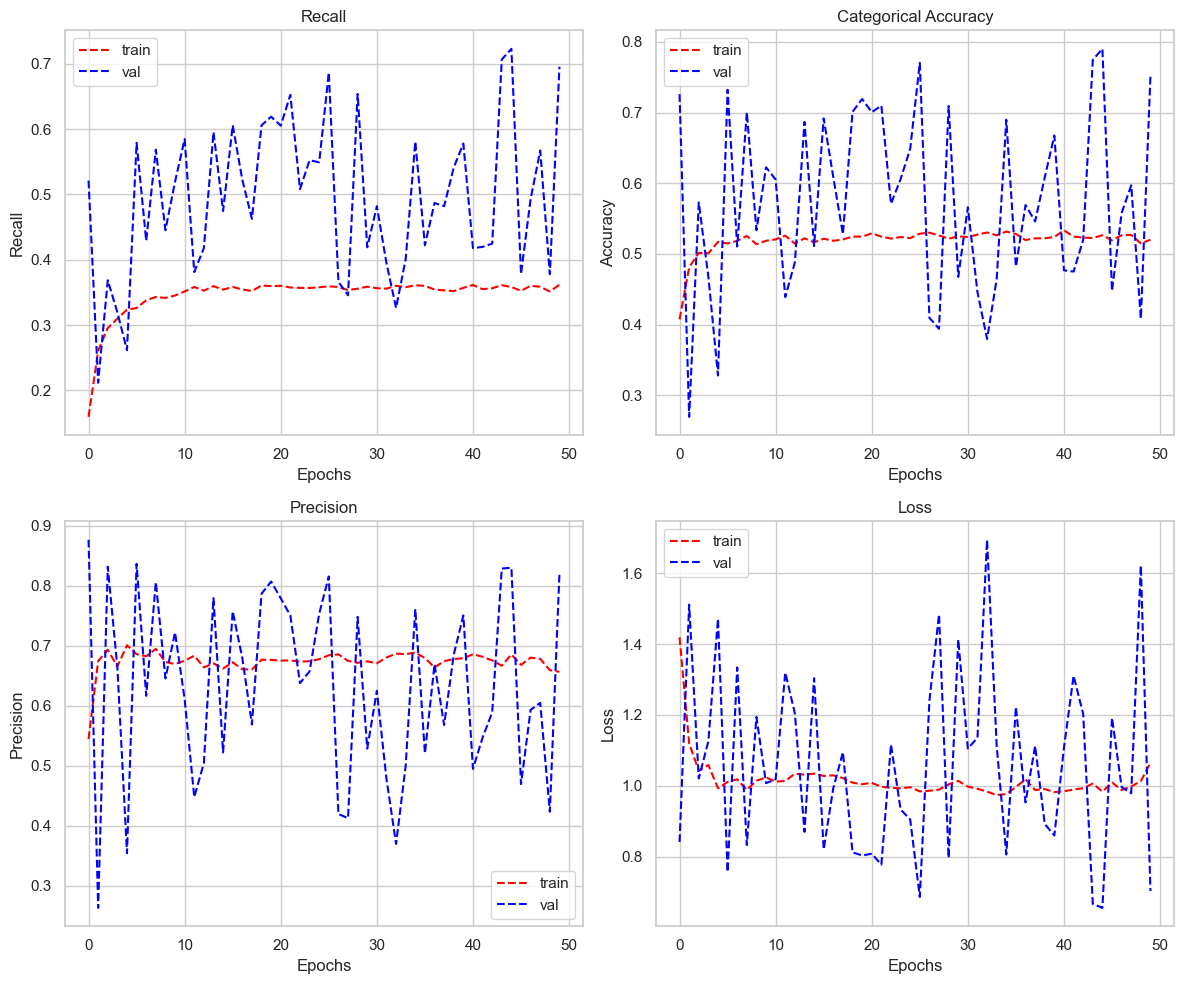

In [218]:
plot_learning_curve(trained_model_ann.train_history.history)

The graphs show:
- Significant gap between training and validation metrics across all measures
- Highly unstable validation performance with extreme fluctuations
- Training metrics remaining relatively stable while validation metrics vary wildly

This indicates severe overfitting and training instability. First, the training instability issue will be tackled first with:
- Early Stopping: Would terminate training around epoch 10 when validation loss reaches its minimum, preventing further overfitting and capturing the best generalizing model.
- ReduceLROnPlateau: Would help tame the extreme validation fluctuations by automatically decreasing the learning rate when metrics plateau, allowing for more stable optimization.
- ModelCheckpoint: Would save the weights at optimal validation performance points, ensuring you retain the best model despite the unstable training process.
These techniques together would address both the overfitting and instability issues evident in all four metrics. 

In [219]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    cooldown=2,
    min_lr=0.00001,
    verbose=1
)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_stable_tune.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

celltype_ann = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_shape)),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

ann_stable_tuned_model = train_nn_for_cell_type_task(
    model=celltype_ann,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.93758, saving model to ann_stable_tune.keras

Epoch 2: val_loss improved from 0.93758 to 0.87381, saving model to ann_stable_tune.keras

Epoch 3: val_loss did not improve from 0.87381

Epoch 4: val_loss did not improve from 0.87381

Epoch 5: val_loss improved from 0.87381 to 0.86304, saving model to ann_stable_tune.keras

Epoch 6: val_loss did not improve from 0.86304

Epoch 7: val_loss improved from 0.86304 to 0.80539, saving model to ann_stable_tune.keras

Epoch 8: val_loss improved from 0.80539 to 0.76243, saving model to ann_stable_tune.keras

Epoch 9: val_loss did not improve from 0.76243

Epoch 10: val_loss did not improve from 0.76243

Epoch 11: val_loss did not improve from 0.76243

Epoch 12: val_loss did not improve from 0.76243

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 13: val_loss did not improve from 0.76243

Epoch 14: val_loss did not improve from 0.76243

Epoch 15: val_loss did not impro

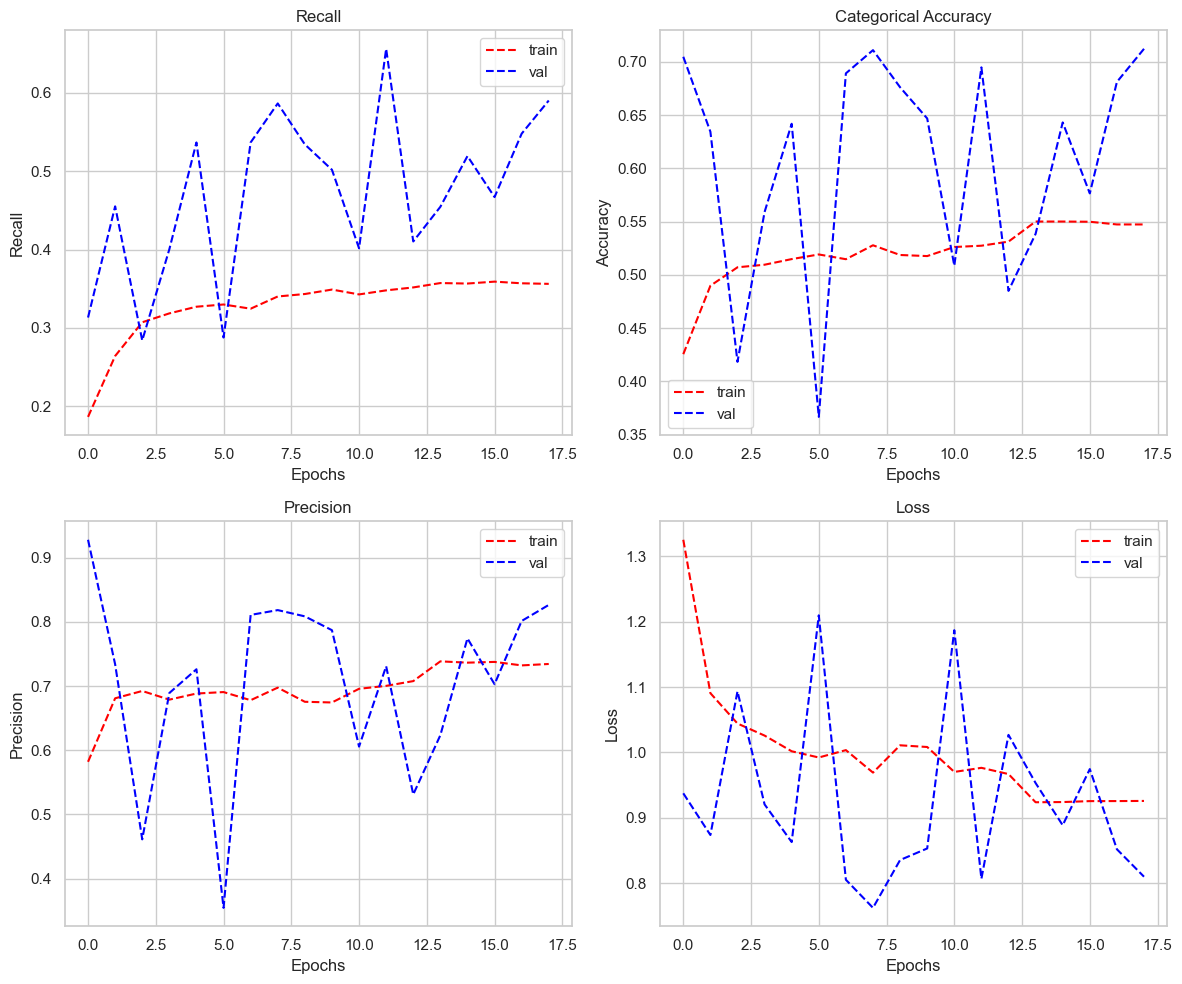

In [220]:
plot_learning_curve(ann_stable_tuned_model.train_history.history)

The learning curve now is more stable, however, all of the graphs show that the model is underfit. Therefore, the number of neurons of the first layer will be tuned (increasing) to make the model more complex.

**Tuning the number of hidden neurons**

In [221]:
celltype_ann_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_256.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_256.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_256_model = train_nn_for_cell_type_task(
    model=celltype_ann_256,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_60 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,156 (2.14 MB)

 Trainable params: 561,156 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.92891, saving model to ann_celltype_256.keras

Epoch 2: val_loss improved from 0.92891 to 0.82899, saving model to ann_celltype_256.keras

Epoch 3: val_loss did not improve from 0.82899

Epoch 4: val_loss did not improve from 0.82899

Epoch 5: val_loss improved from 0.82899 to 0.67909, saving model to ann_celltype_256.keras

Epoch 6: val_loss did not improve from 0.67909

Epoch 7: val_loss did not improve from 0.67909

Epoch 8: val_loss did not improve from 0.67909

Epoch 9: val_loss did not improve from 0.67909

Epoch 10: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 10: val_loss did not improve from 0.67909

Epoch 11: val_loss did not improve from 0.67909

Epoch 12: val_loss did not improve from 0.67909

Epoch 13: val_loss did not improve from 0.67909

Epoch 14: val_loss did not improve from 0.67909

Epoch 15: val_loss did not improve from 0.67909
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.


In [222]:
celltype_ann_512 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_512.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_256.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_512_model = train_nn_for_cell_type_task(
    model=celltype_ann_512,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_61 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 512)            │     1,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,308 (4.28 MB)

 Trainable params: 1,122,308 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.20531, saving model to ann_celltype_256.keras

Epoch 2: val_loss improved from 1.20531 to 1.02972, saving model to ann_celltype_256.keras

Epoch 3: val_loss improved from 1.02972 to 0.79886, saving model to ann_celltype_256.keras

Epoch 4: val_loss did not improve from 0.79886

Epoch 5: val_loss improved from 0.79886 to 0.79385, saving model to ann_celltype_256.keras

Epoch 6: val_loss did not improve from 0.79385

Epoch 7: val_loss improved from 0.79385 to 0.77224, saving model to ann_celltype_256.keras

Epoch 8: val_loss did not improve from 0.77224

Epoch 9: val_loss did not improve from 0.77224

Epoch 10: val_loss did not improve from 0.77224

Epoch 11: val_loss did not improve from 0.77224

Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 12: val_loss did not improve from 0.77224

Epoch 13: val_loss did not improve from 0.77224

Epoch 14: val_loss did not improve from 0.77224

Epoch 15: val_loss did not improve from 0.77

In [223]:
celltype_ann_1024 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_1024.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_1024.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_1024_model = train_nn_for_cell_type_task(
    model=celltype_ann_1024,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_62 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1024)           │     2,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,244,612 (8.56 MB)

 Trainable params: 2,244,612 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.04018, saving model to ann_celltype_1024.keras

Epoch 2: val_loss improved from 1.04018 to 0.85088, saving model to ann_celltype_1024.keras

Epoch 3: val_loss improved from 0.85088 to 0.80970, saving model to ann_celltype_1024.keras

Epoch 4: val_loss did not improve from 0.80970

Epoch 5: val_loss improved from 0.80970 to 0.71097, saving model to ann_celltype_1024.keras

Epoch 6: val_loss did not improve from 0.71097

Epoch 7: val_loss did not improve from 0.71097

Epoch 8: val_loss did not improve from 0.71097

Epoch 9: val_loss did not improve from 0.71097

Epoch 10: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 10: val_loss did not improve from 0.71097

Epoch 11: val_loss did not improve from 0.71097

Epoch 12: val_loss did not improve from 0.71097

Epoch 13: val_loss did not improve from 0.71097

Epoch 14: val_loss did not improve from 0.71097

Epoch 15: val_loss did not improve from 0.71097
Epoch 15: early stopping
Restoring m

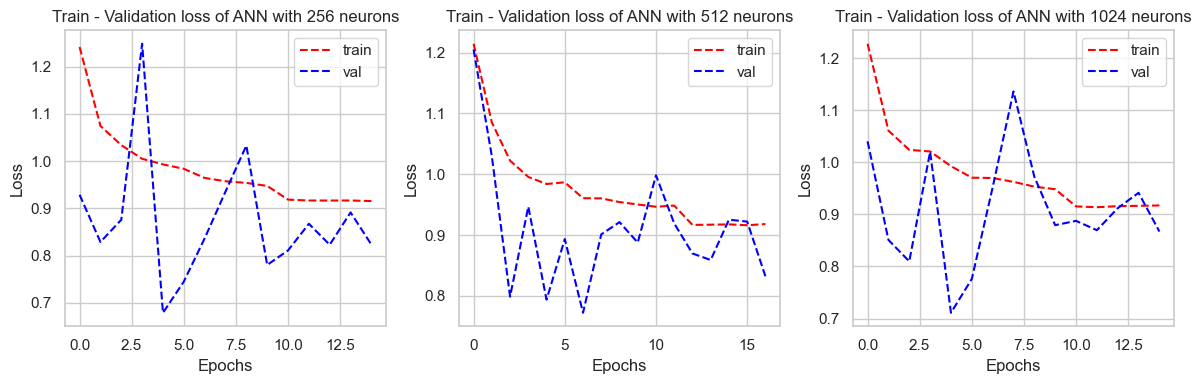

In [224]:
# Loss
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))


ann_256_train_history = ann_256_model.train_history.history

plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(ann_256_train_history['loss'])), y=ann_256_train_history['loss'], label='train', linestyle='--', color='red')
sns.lineplot(x=range(len(ann_256_train_history['val_loss'])), y=ann_256_train_history['val_loss'], label='val', linestyle='--', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train - Validation loss of ANN with 256 neurons")

ann_512_train_history = ann_512_model.train_history.history
plt.subplot(1, 3, 2)
sns.lineplot(x=range(len(ann_512_train_history['loss'])), y=ann_512_train_history['loss'], label='train', linestyle='--', color='red')
sns.lineplot(x=range(len(ann_512_train_history['val_loss'])), y=ann_512_train_history['val_loss'], label='val', linestyle='--', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train - Validation loss of ANN with 512 neurons")

ann_1024_train_history = ann_1024_model.train_history.history
plt.subplot(1, 3, 3)
sns.lineplot(x=range(len(ann_1024_train_history['loss'])), y=ann_1024_train_history['loss'], label='train', linestyle='--', color='red')
sns.lineplot(x=range(len(ann_1024_train_history['val_loss'])), y=ann_1024_train_history['val_loss'], label='val', linestyle='--', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train - Validation loss of ANN with 1024 neurons")

plt.tight_layout()
plt.show()

As the MLP network is still underfitting, another layer to make the model more complex.

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_63 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 1024)           │     2,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,364 (10.56 MB)

 Trainable params: 2,767,364 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.94492, saving model to ann_celltype_1024_512.keras

Epoch 2: val_loss improved from 0.94492 to 0.93929, saving model to ann_celltype_1024_512.keras

Epoch 3: val_loss improved from 0.93929 to 0.75523, saving model to ann_celltype_1024_512.keras

Epoch 4: val_loss did not improve from 0.75523

Epoch 5: val_loss did not improve from 0.75523

Epoch 6: val_loss did not improve from 0.75523

Epoch 7: val_loss did not improve from 0.75523

Epoch 8: val_loss improved from 0.75523 to 0.73417, saving model to ann_celltype_1024_512.keras

Epoch 9: val_loss did not improve from 0.73417

Epoch 10: val_loss did not improve from 0.73417

Epoch 11: val_loss did not improve from 0.73417

Epoch 12: val_loss did not improve from 0.73417

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 13: val_loss did not improve from 0.73417

Epoch 14: val_loss did not improve from 0.73417

Epoch 15: val_loss did not improve from 0.73417

Epoch 16: val_loss 

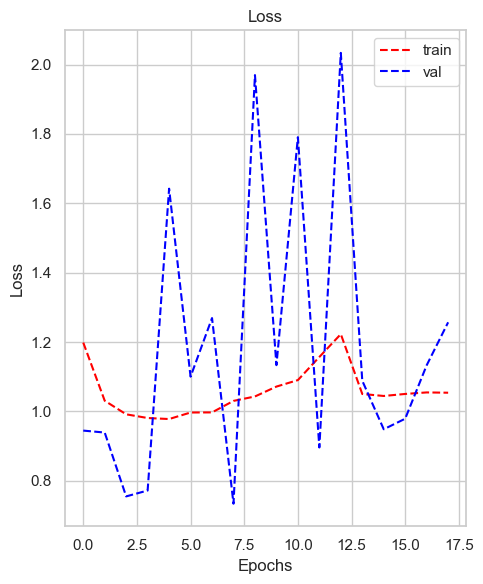

In [225]:
celltype_ann_1024_512 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_1024_512.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_1024_512.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_1024_512_model = train_nn_for_cell_type_task(
    model=celltype_ann_1024_512,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)
plot_train_val_loss(ann_1024_512_model.train_history.history)

Loaded best model from: ann_stable_tune.keras
Found 2128 validated image filenames.
18/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.28      0.41       307
           1       0.62      0.85      0.72       618
           2       0.81      0.90      0.85      1051
           3       0.00      0.00      0.00       152

    accuracy                           0.73      2128
   macro avg       0.55      0.51      0.49      2128
weighted avg       0.69      0.73      0.69      2128


 Weighted F1 Score
0.6889303318218494
📈 Generating ROC Curve...
Found 2128 validated image filenames.
 93/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


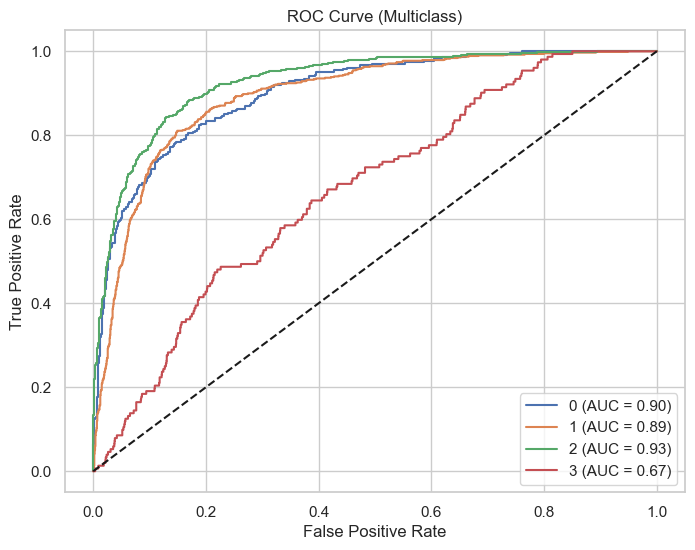

(0.6889303318218494,
 {'0': 0.9015324292948536,
  '1': 0.8947368139051416,
  '2': 0.927846937125804,
  '3': 0.6683075191774984})

In [159]:
# TODO: Evaluate the stable model here
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
ann_stable_tuned_model.load_best_model('ann_stable_tune.keras')

evaluate_model(ann_stable_tuned_model, X_test, y_test)

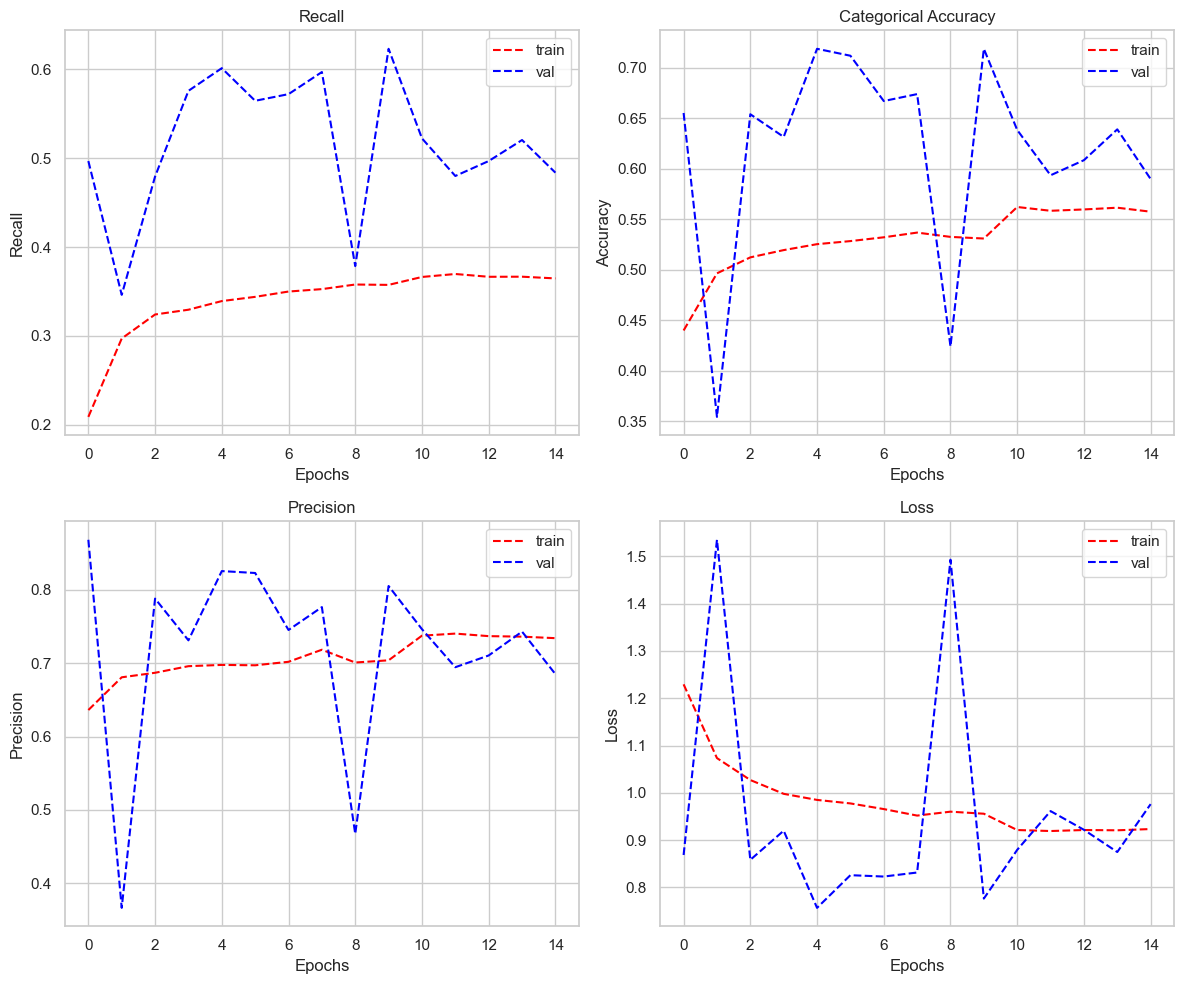

In [178]:
plot_learning_curve(ann_256_model.train_history.history)

In [163]:
celltype_ann_reg = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_reg.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_128.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_with_reg_train_model = train_nn_for_cell_type_task(
    model=celltype_ann_reg,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_41 (Flatten)            │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │       280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,580 (1.07 MB)

 Trainable params: 280,580 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.06446, saving model to ann_celltype_ann_reg.keras

Epoch 2: val_loss improved from 1.06446 to 1.04424, saving model to ann_celltype_ann_reg.keras

Epoch 3: val_loss improved from 1.04424 to 0.96892, saving model to ann_celltype_ann_reg.keras

Epoch 4: val_loss did not improve from 0.96892

Epoch 5: val_loss did not improve from 0.96892

Epoch 6: val_loss did not improve from 0.96892

Epoch 7: val_loss did not improve from 0.96892

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 8: val_loss did not improve from 0.96892

Epoch 9: val_loss did not improve from 0.96892

Epoch 10: val_loss did not improve from 0.96892

Epoch 11: val_loss did not improve from 0.96892

Epoch 12: val_loss did not improve from 0.96892

Epoch 13: val_loss did not improve from 0.96892
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
🧹 Deleting augmented image directory: ./data/aug/neural_net


Loaded best model from: ann_celltype_ann_reg.keras
Found 2128 validated image filenames.
18/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.27      0.41       307
           1       0.77      0.66      0.71       618
           2       0.68      0.97      0.80      1051
           3       0.00      0.00      0.00       152

    accuracy                           0.71      2128
   macro avg       0.56      0.48      0.48      2128
weighted avg       0.68      0.71      0.66      2128


 Weighted F1 Score
0.6625361195568261
📈 Generating ROC Curve...
Found 2128 validated image filenames.
 96/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


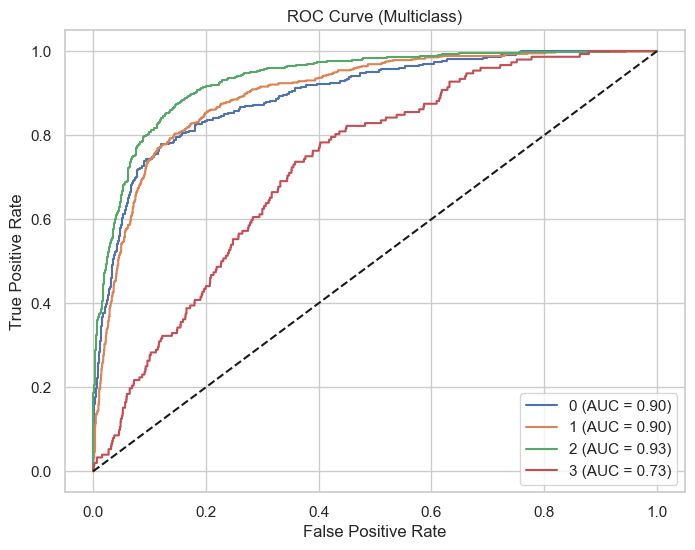

(0.6625361195568261,
 {'0': 0.8960767162689361,
  '1': 0.9004704344285134,
  '2': 0.9338005012690749,
  '3': 0.7276079400170467})

In [168]:
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
ann_with_reg_train_model.load_best_model('ann_celltype_ann_reg.keras')

evaluate_model(ann_with_reg_train_model, X_test, y_test)

In [ ]:
celltype_ann_reg_dropout = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Flatten(),  # Converts 27x27x3 → 2187 vector
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    tf.keras.layers.Dense(celltype_n_classes, activation='softmax')
])

celltype_ann_reg_dropout.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'ann_celltype_ann_reg_dropout.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
ann_with_reg_dropout_model = train_nn_for_cell_type_task(
    model=celltype_ann_reg_dropout,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


In [ ]:
plot_learning_curve(ann_with_reg_dropout_model.train_history.history)

In [ ]:
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
ann_with_reg_dropout_model.load_best_model('ann_celltype_ann_reg_dropout.keras')

evaluate_model(ann_with_reg_dropout_model, X_test, y_test)

Based on the trained and tuned models, despite the performance of the MLP is increased but the overfitting issue remains. 
In the task of classifying cancer cells from images, Multi-Layer Perceptrons (MLPs) are prone to overfitting due to the following limitations:

- **Loss of Spatial Structure**: MLPs require input images (e.g., 27×27×3) to be flattened into 1D vectors (e.g., 2187 features). This destroys the 2D spatial relationships between pixels—critical for identifying visual patterns in cell structures—treating each pixel as an independent feature.

- **Excessive Parameters**: Flattened inputs into fully connected layers result in very large weight matrices. This leads to a high number of trainable parameters, increasing the risk of memorizing training data instead of learning generalizable patterns—especially when the dataset is limited, as is often the case in medical imaging.

#### Conv Neural Networks

ConvNet is the deep learning approach that is efficient in computer vision by leveraging feature selection and extraction in the model instead of handcraft fine tuning. In this assignment, three main architecture including LeNet, VGG and RESNET are examined on given dataset. The LeNET is chosen as the baseline model as it is the first method. Then the more complex including VGG and RESET will be examined.

In [226]:
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

reg_lambda = 0.001
baseline_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
baseline_cnn.summary()

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_73 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_64 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,500 (369.14 KB)

 Trainable params: 94,500 (369.14 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
cnn_baseline_model = train_nn_for_cell_type_task(
    model=baseline_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🧹 Deleting augmented image directory: ./data/aug/neural_net


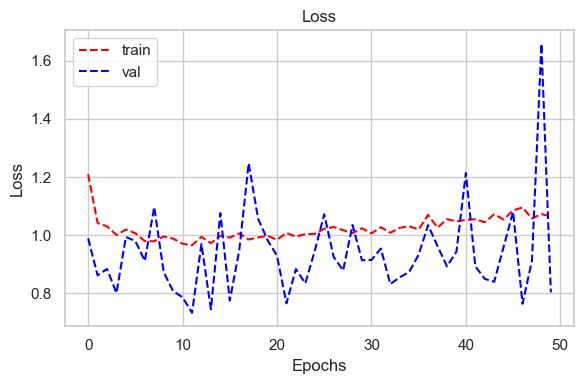

In [239]:
plot_train_val_loss(cnn_baseline_model.train_history.history)

Similar to the MLP, the learning curve specially the validation loss is not stable. Therefore, learning_rate scheduler, early stopper and checkpoint will be applied.

In [182]:
baseline_cnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
cnn_baseline_model = train_nn_for_cell_type_task(
    model=baseline_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,964 (1.51 MB)

 Trainable params: 395,812 (1.51 MB)

 Non-trainable params: 1,152 (4.50 KB)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 3.44863, saving model to cnn_baseline.keras

Epoch 2: val_loss improved from 3.44863 to 1.50128, saving model to cnn_baseline.keras

Epoch 3: val_loss improved from 1.50128 to 1.03163, saving model to cnn_baseline.keras

Epoch 4: val_loss did not improve from 1.03163

Epoch 5: val_loss did not improve from 1.03163

Epoch 6: val_loss did not improve from 1.03163

Epoch 7: val_loss improved from 1.03163 to 0.81982, saving model to cnn_baseline.keras

Epoch 8: val_loss did not improve from 0.81982

Epoch 9: val_loss did not improve from 0.81982

Epoch 10: val_loss did not improve from 0.81982

Epoch 11: val_loss did not improve from 0.81982

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_loss did not improve from 0.81982

Epoch 13: val_loss did not improve from 0.81982

Epoch 14: val_loss did not improve from 0.81982

Epoch 15: val_loss did not improve from 0.81982

Epoch 16: val_loss did not improve fro

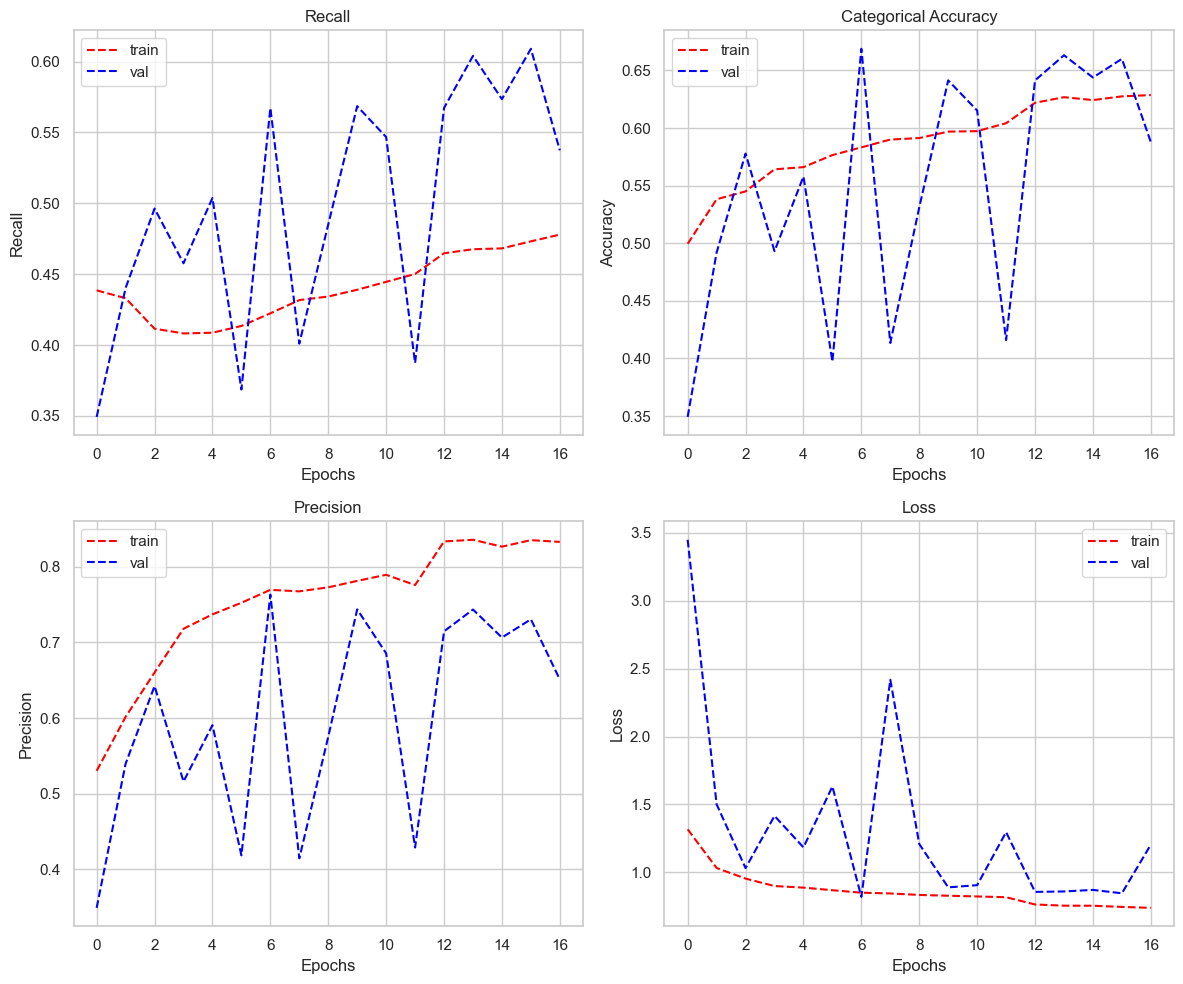

In [183]:
plot_learning_curve(cnn_baseline_model.train_history.history)

As the model is underfit, the more complex is used. 

In [248]:
reg_lambda = 0.001
baseline_cnn = tf.keras.Sequential([
        # Input layer: 27x27 images with 3 channels (RGB)
        layers.Input(shape=(27, 27, 3)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Third convolutional block - smaller filter size due to small input dimensions
        layers.Conv2D(128, (2, 2), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')  # B
])
baseline_cnn.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
cnn_baseline_model = train_nn_for_cell_type_task(
    model=baseline_cnn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_86 (Conv2D)              │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_67 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,356 (970.14 KB)

 Trainable params: 247,460 (966.64 KB)

 Non-trainable params: 896 (3.50 KB)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 3.18747, saving model to cnn_baseline.keras

Epoch 2: val_loss improved from 3.18747 to 1.80850, saving model to cnn_baseline.keras

Epoch 3: val_loss improved from 1.80850 to 1.27488, saving model to cnn_baseline.keras

Epoch 4: val_loss did not improve from 1.27488

Epoch 5: val_loss did not improve from 1.27488

Epoch 6: val_loss improved from 1.27488 to 1.14140, saving model to cnn_baseline.keras

Epoch 7: val_loss did not improve from 1.14140

Epoch 8: val_loss improved from 1.14140 to 1.11599, saving model to cnn_baseline.keras

Epoch 9: val_loss did not improve from 1.11599

Epoch 10: val_loss did not improve from 1.11599

Epoch 11: val_loss did not improve from 1.11599

Epoch 12: val_loss improved from 1.11599 to 1.04840, saving model to cnn_baseline.keras

Epoch 13: val_loss improved from 1.04840 to 1.02080, saving model to cnn_baseline.keras

Epoch 14: val_loss did not improve from 1.02080

Epoch 15: val_loss improved from 1.02080 to 0.

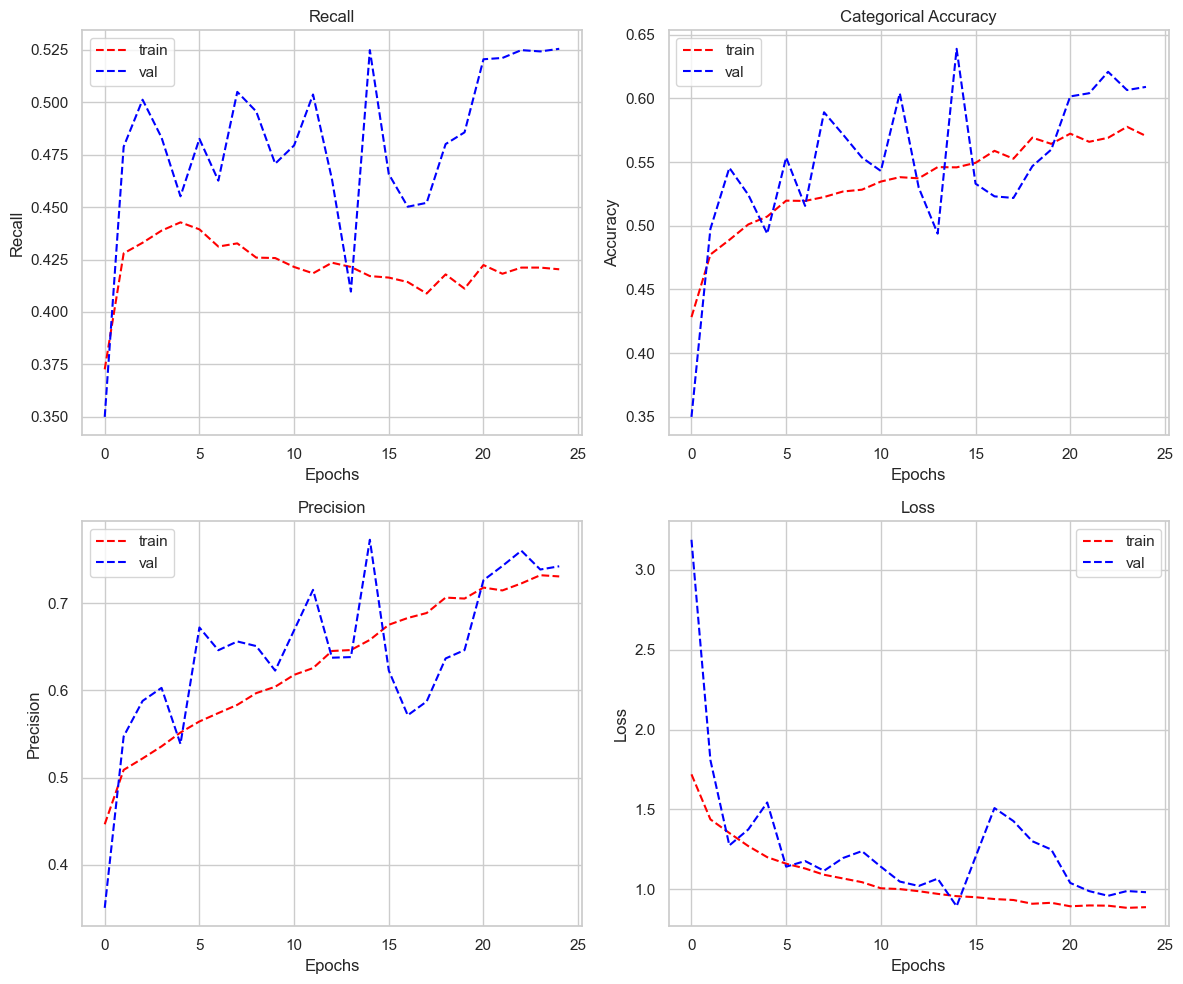

In [249]:
plot_learning_curve(cnn_baseline_model.train_history.history)

Loaded best model from: cnn_baseline.keras
Found 2128 validated image filenames.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.43      0.55       307
           1       0.86      0.57      0.69       618
           2       0.70      0.96      0.81      1051
           3       0.36      0.26      0.30       152

    accuracy                           0.72      2128
   macro avg       0.67      0.56      0.59      2128
weighted avg       0.73      0.72      0.70      2128


 Weighted F1 Score
0.7019661242931384
📈 Generating ROC Curve...
Found 2128 validated image filenames.
 30/133 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


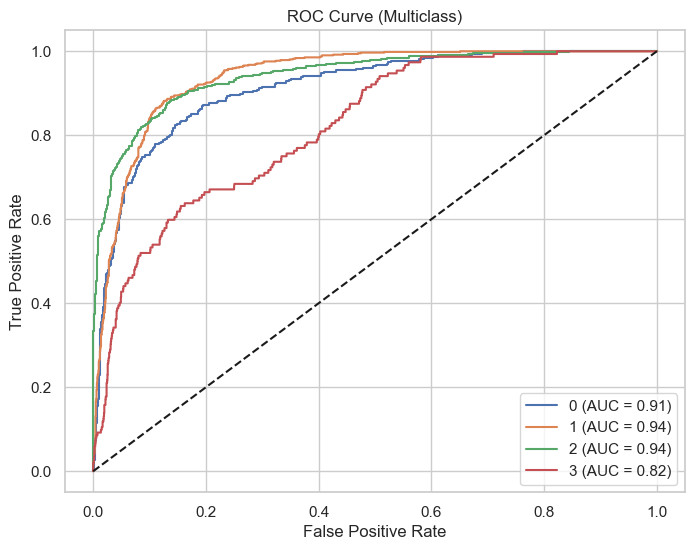

0.7019661242931384
{'0': 0.9116460691140458, '1': 0.9392223365267152, '2': 0.9423452219091868, '3': 0.8190906003622416}


In [252]:
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
cnn_baseline_model.load_best_model('cnn_baseline.keras')

a, b = evaluate_model(cnn_baseline_model, X_test, y_test)

print(a)

print(b)

### RESNET

In [258]:
def create_baseline_resnet_model(input_shape=(27, 27, 3), num_classes=4):
    """
    Creates a baseline ResNet model for 27x27 histopathology images
    
    Parameters:
    -----------
    input_shape : tuple
        Input image dimensions (height, width, channels)
    num_classes : int
        Number of cell types to classify
    """
    from tensorflow.keras import layers, models
    
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # First Residual Block - 16 filters
    residual = x
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 27x27 -> 13x13
    
    # Second Residual Block - 32 filters with projection shortcut
    residual = layers.Conv2D(32, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    
    # Global Average Pooling and FC layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [264]:
resnet_baseline_celltype = create_baseline_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_baseline.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
resnet_baseline_model = train_nn_for_cell_type_task(
    model=resnet_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=16,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.21259, saving model to resnet_baseline.keras

Epoch 2: val_loss improved from 1.21259 to 0.79485, saving model to resnet_baseline.keras

Epoch 3: val_loss did not improve from 0.79485

Epoch 4: val_loss did not improve from 0.79485

Epoch 5: val_loss did not improve from 0.79485

Epoch 6: val_loss did not improve from 0.79485

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 7: val_loss did not improve from 0.79485

Epoch 8: val_loss did not improve from 0.79485

Epoch 9: val_loss did not improve from 0.79485

Epoch 10: val_loss did not improve from 0.79485

Epoch 11: val_loss did not improve from 0.79485

Epoch 12: val_loss did not improve from 0.79485

Epoch 13: val_loss did not improve from 0.79485

Epoch 14: val_loss did not improve from 0.79485

Epoch 15: val_loss did not improve from 0.79485

Epoch 16: val_loss did not improve from 0.79485

Epoch 17: val_loss did not improve from 0.79485

Epoch 18: val_loss did not impro

KeyboardInterrupt: 

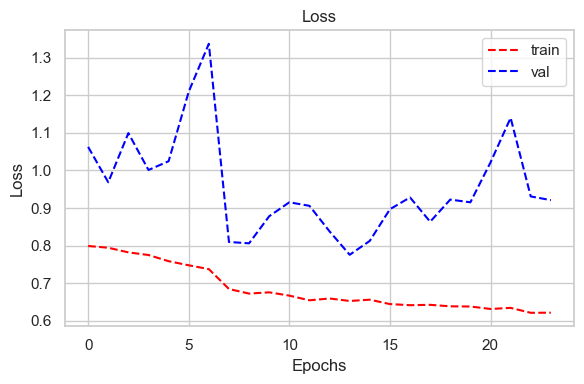

In [263]:
plot_train_val_loss(resnet_baseline_model.train_history.history)

In [186]:
def create_resnet_model(input_shape=(27, 27, 3), num_classes=4):
    """
    Creates a ResNet-based model adapted for 27x27 histopathology images
    
    Parameters:
    -----------
    input_shape : tuple
        Input image dimensions (height, width, channels)
    num_classes : int
        Number of cell types to classify
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # First Residual Block - 32 filters
    residual = x
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 27x27 -> 13x13
    
    # Second Residual Block - 64 filters with projection shortcut
    residual = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    # Spatial reduction
    x = layers.MaxPooling2D((2, 2))(x)  # 13x13 -> 6x6
    
    # Third Residual Block - 128 filters with projection shortcut
    residual = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    # Add the residual connection with projection
    x = layers.add([x, residual])
    x = layers.Activation('relu')(x)
    
    # Global Average Pooling and FC layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

In [265]:
resnet_enhanced_celltype = create_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_enhanced.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
resnet_enhanced_model = train_nn_for_cell_type_task(
    model=resnet_enhanced_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reducer, early_stopper, checkpoint],
    train_df=nn_train_celtype,
    val_df=nn_val_celtype
)

N required: 0
N required: 1186
N required: 1235
N required: 1285
🔍 Class distribution after balancing:
label
2    2467
1    2467
0    2467
3    2467
Name: count, dtype: int64
Found 9868 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.33143, saving model to resnet_enhanced.keras

Epoch 2: val_loss improved from 1.33143 to 1.02626, saving model to resnet_enhanced.keras

Epoch 3: val_loss did not improve from 1.02626

Epoch 4: val_loss did not improve from 1.02626

Epoch 5: val_loss did not improve from 1.02626

Epoch 6: val_loss did not improve from 1.02626

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 7: val_loss did not improve from 1.02626

Epoch 8: val_loss improved from 1.02626 to 0.85866, saving model to resnet_enhanced.keras

Epoch 9: val_loss improved from 0.85866 to 0.85532, saving model to resnet_enhanced.keras

Epoch 10: val_loss did not improve from 0.85532

Epoch 11: val_loss did not improve from 0.85532

Epoch 12: val_loss did not improve from 0.85532

Epoch 13: val_loss improved from 0.85532 to 0.84759, saving model to resnet_enhanced.keras

Epoch 14: val_loss did not improve from 0.84759

Epoch 15: val_loss improved from 0.84759 to 0.8246

Loaded best model from: resnet_enhanced.keras
Found 2128 validated image filenames.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       307
           1       0.81      0.89      0.85       618
           2       0.89      0.90      0.89      1051
           3       0.54      0.37      0.44       152

    accuracy                           0.82      2128
   macro avg       0.74      0.70      0.72      2128
weighted avg       0.81      0.82      0.82      2128


 Weighted F1 Score
0.8161538600653502
📈 Generating ROC Curve...
Found 2128 validated image filenames.
  6/133 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


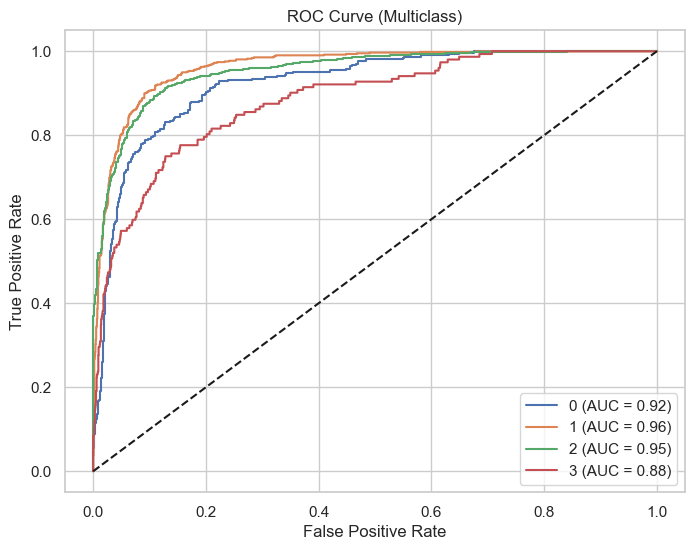

(0.8161538600653502,
 {'0': 0.9235270022019615,
  '1': 0.9624804432156713,
  '2': 0.9535076025220708,
  '3': 0.8835249973364586})

In [319]:
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
resnet_enhanced_model.load_best_model('resnet_enhanced.keras')

evaluate_model(resnet_enhanced_model, X_test, y_test)

## Using extra data to improve the current accuracy

Analysis on the given data: 
The given data does not have the labels for the cell type but only with the cancerous status. So, one possible way is to train the embeddings via the encoder/decoder neural network (i.e. similar to what BERT do), then fine tuned on the given dataset. 

Running the transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets


In [269]:
# Load the extra data
celltype_extra_df = pd.read_csv('./data/data_labels_extraData.csv')


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [309]:
# Step 1: Get predicted probabilities
semi_pred_proba = resnet_enhanced_model.predict_proba(celltype_extra_df[['ImageName']])

# Step 2: Get predicted classes and confidence levels
predicted_indices = np.argmax(semi_pred_proba, axis=1)
confidence_scores = np.max(semi_pred_proba, axis=1)
predicted_class_names = [resnet_enhanced_model.class_names[i] for i in predicted_indices]

# Step 3: Add predictions and confidence to the DataFrame
semi_data = celltype_extra_df.copy()
semi_data['cellType'] = predicted_class_names
semi_data['confidence'] = confidence_scores

# Step 4: Apply a confidence threshold (e.g., 0.85)
threshold = 0.99
semi_data_high_conf = semi_data[semi_data['confidence'] >= threshold].reset_index(drop=True)

# Preview high-confidence predictions
semi_data_high_conf.head()


Found 10384 validated image filenames.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


649/649 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


,InstanceID,patientID,ImageName,isCancerous,cellType,confidence
0,12748,61,12748.png,1,2,0.994525
1,12750,61,12750.png,1,2,0.999683
2,12751,61,12751.png,1,2,0.997734
3,12754,61,12754.png,1,2,0.999905
4,12756,61,12756.png,1,2,0.994878


In [310]:
semi_data_high_conf.shape

(2187, 6)

In [311]:
semi_data_high_conf.drop('confidence', axis=1, inplace=True) # Drops 'col2' permanently
semi_train_filtered_dfs = [nn_train_celtype, semi_data_high_conf]
semi_train_filtered = pd.concat(semi_train_filtered_dfs)
semi_train_filtered.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,4461,13,4461.png,fibroblast,0,0
1,4462,13,4462.png,fibroblast,0,0
2,4463,13,4463.png,fibroblast,0,0
3,4464,13,4464.png,fibroblast,0,0
4,4465,13,4465.png,fibroblast,0,0


In [ ]:
resnet_semi_celltype = create_resnet_model()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'resnet_semi_filtered.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
resnet_semi_model = train_nn_for_cell_type_task(
    model=resnet_semi_celltype,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    epochs=30,
    batch_size=32,
    callbacks=[lr_reducer, checkpoint],
    train_df=semi_train_filtered,
    val_df=nn_val_celtype
)

N required: 0
N required: 3373
N required: 3422
N required: 3472
🔍 Class distribution after balancing:
label
2    4654
1    4654
0    4654
3    4654
Name: count, dtype: int64
Found 18616 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.32641, saving model to resnet_semi_filtered.keras

Epoch 2: val_loss improved from 2.32641 to 0.97529, saving model to resnet_semi_filtered.keras

Epoch 3: val_loss did not improve from 0.97529

Epoch 4: val_loss did not improve from 0.97529

Epoch 5: val_loss did not improve from 0.97529

Epoch 6: val_loss did not improve from 0.97529


In [ ]:
plot_train_val_loss(resnet_semi_model.train_history.history)

In [ ]:
X_test = cell_type_test[['ImageName']]
y_test = cell_type_test['cellType'].astype(str)
resnet_semi_model.load_best_model('resnet_semi_filtered.keras')

evaluate_model(resnet_semi_model, X_test, y_test)